Authors: Eric Zabele, Mingyu Wan, Amin Majdi

COMP 5450 Machine Learning Project

Objective:  The objective of this project was to predict the obesity level of obesity based on results from a given survey.

In [2]:
# Import the necessary libraries for this project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter
#%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from pandas.api.types import is_string_dtype, is_numeric_dtype

from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree as pt

# Models
from sklearn.naive_bayes import GaussianNB as nb
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#Ensemble Method
from sklearn.ensemble import RandomForestClassifier as RF

In [2]:
path = "~/UML/Classes/MachineLearning/Project/ObesityDataSet_raw_and_data_sinthetic.csv"
PATH = "~/UML/Classes/MachineLearning/Project/"

In [3]:
ds = pd.read_csv(path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/csrobot/UML/Classes/MachineLearning/Project/ObesityDataSet_raw_and_data_sinthetic.csv'

In [4]:
ds.info()

NameError: name 'ds' is not defined

Upon inspection of this dataset, we can see that we have 17 columns, 16 features that we will use to try and predict "NObeyesdad", or obesity.  We have eight features that are numerical values, age, height, weight, likert scale values,etc. and eight features that are non-numerical, either bools, likert scale items, etc.  To show what an entry looks like for a person, lets examine the first entry and also rename these columns as they aren't providing too much context. 

In [5]:
ds.columns = ["Gender", "Age", "Height", "Weight", 
              "Family History W/ Obesity", "Frequent Consumption High Caloric Food",
             "Frequency of Vegetable Consumption", "Number Meals", 
              "Consume Food Between Meals", "Smoke", "Water Consumption",
             "Monitor Calorie Consumption", "Physical Activity Frequency",
              "Time Using Tech", "Alcohol", "Mode of Transport", "Obesity"]
for col in ds.columns:
    print("Column: {0}: {1}".format(col, ds[col][0]))

NameError: name 'ds' is not defined

For the categorical, let's check out the unique values.

In [204]:
for col in ds.columns:
    if is_string_dtype(ds[col]):
        print("{0}: {1}".format(col,ds[col].unique()))

Gender: ['Female' 'Male']
Family History W/ Obesity: ['yes' 'no']
Frequent Consumption High Caloric Food: ['no' 'yes']
Consume Food Between Meals: ['Sometimes' 'Frequently' 'Always' 'no']
Smoke: ['no' 'yes']
Monitor Calorie Consumption: ['no' 'yes']
Alcohol: ['no' 'Sometimes' 'Frequently' 'Always']
Mode of Transport: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Obesity: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


In [205]:
for col in ds.columns:
    if is_numeric_dtype(ds[col]):
        print("{0}: {1}".format(col,ds[col].unique()))

Age: [21.       23.       27.       ... 22.524036 24.361936 23.664709]
Height: [1.62     1.52     1.8      ... 1.752206 1.73945  1.738836]
Weight: [ 64.        56.        77.       ... 133.689352 133.346641 133.472641]
Frequency of Vegetable Consumption: [2.       3.       1.       2.450218 2.880161 2.00876  2.596579 2.591439
 2.392665 1.123939 2.027574 2.658112 2.88626  2.714447 2.750715 1.4925
 2.205439 2.059138 2.310423 2.823179 2.052932 2.596364 2.767731 2.815157
 2.737762 2.568063 2.524428 2.971574 1.0816   1.270448 1.344854 2.959658
 2.725282 2.844607 2.44004  2.432302 2.592247 2.449267 2.929889 2.015258
 1.031149 1.592183 1.21498  1.522001 2.703436 2.362918 2.14084  2.5596
 2.336044 1.813234 2.724285 2.71897  1.133844 1.757466 2.979383 2.204914
 2.927218 2.88853  2.890535 2.530066 2.241606 1.003566 2.652779 2.897899
 2.483979 2.945967 2.478891 2.784464 1.005578 2.938031 2.842102 1.889199
 2.943749 2.33998  1.950742 2.277436 2.371338 2.984425 2.977018 2.663421
 2.753752 2.318355 

Our numerical data is not all likert, all though I think we can assume it was meant to be.  This may be from synthesizing some of the data.  Now we will reformat by rounding.  

In [206]:
ds["Height"] *= 100
for col in ds.columns:
    if is_numeric_dtype(ds[col]):
        ds[col] = ds[col].round()
        print("{0}: {1}".format(col,ds[col].unique()))

Age: [21. 23. 27. 22. 29. 24. 26. 41. 30. 52. 20. 19. 31. 39. 17. 25. 55. 38.
 18. 15. 61. 44. 34. 36. 32. 35. 40. 45. 33. 51. 56. 28. 16. 37. 14. 42.
 43. 46. 48. 47.]
Height: [162. 152. 180. 178. 150. 164. 172. 185. 165. 177. 170. 193. 153. 171.
 169. 160. 175. 168. 158. 179. 156. 167. 166. 181. 182. 155. 161. 163.
 176. 157. 188. 187. 189. 174. 183. 192. 173. 184. 191. 148. 159. 154.
 190. 186. 145. 198. 151. 146. 149. 195. 194.]
Weight: [ 64.  56.  77.  87.  90.  53.  55.  68. 105.  80.  99.  60.  66. 102.
  78.  82.  70.  50.  65.  52.  76.  83.  62.  49.  48.  67.  88.  75.
  72.  54.  44.  58.  57.  69.  95. 112.  85.  45.  91.  86.  93.  84.
  42.  63.  51.  61. 109.  94.  59. 130.  79.  96.  98.  74. 118.  40.
  71. 100.  73. 114. 121. 120.  47.  81. 115. 107. 110. 173.  97. 125.
  92. 108.  39. 113.  89. 104. 127. 111. 138. 165. 133. 134.  43.  41.
  46. 101. 106. 103. 119. 117. 122. 116. 129. 124. 126. 123. 128. 150.
 132. 152. 131. 142. 153. 136. 139. 156. 137. 141. 144. 14

In [207]:
ds.describe()

,Age,Height,Weight,Frequency of Vegetable Consumption,Number Meals,Water Consumption,Physical Activity Frequency,Time Using Tech
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.315964,170.162009,86.586452,2.423496,2.687826,2.014685,1.006632,0.664614
std,6.357078,9.336840,26.190136,0.583905,0.809680,0.688616,0.895462,0.674009
min,14.000000,145.000000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,163.000000,65.500000,2.000000,3.000000,2.000000,0.000000,0.000000
50%,23.000000,170.000000,83.000000,2.000000,3.000000,2.000000,1.000000,1.000000
75%,26.000000,177.000000,107.000000,3.000000,3.000000,2.000000,2.000000,1.000000
max,61.000000,198.000000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


This gives us a good idea of what information we are working with.  As we can see, some value are on a likert scale, and others are real measurements.  Let's get a little more information about what we are predicting.  

In [208]:
ds['Obesity'].unique()

array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

Here we see the seven classifications of obesity provided in the dataset that we are trying to predict.  

Now let's see what values for each feature are most popular and least popular within the obesity ranks; excluding gender, age, height, weight.

In [209]:
classes = ds["Obesity"].unique()

for cls in classes:
    sub_df = ds.loc[ds["Obesity"] == cls]
    print(cls)
    for col in sub_df:
        if col in ["Gender", "Age", "Height", "Weight", "Obesity"]:
            continue
        print(sub_df[col].value_counts())
        print("")

Normal_Weight
yes    155
no     132
Name: Family History W/ Obesity, dtype: int64

yes    208
no      79
Name: Frequent Consumption High Caloric Food, dtype: int64

2.0    155
3.0    114
1.0     18
Name: Frequency of Vegetable Consumption, dtype: int64

3.0    206
1.0     52
4.0     29
Name: Number Meals, dtype: int64

Sometimes     159
Frequently     83
Always         35
no             10
Name: Consume Food Between Meals, dtype: int64

no     274
yes     13
Name: Smoke, dtype: int64

2.0    164
1.0     83
3.0     40
Name: Water Consumption, dtype: int64

no     257
yes     30
Name: Monitor Calorie Consumption, dtype: int64

1.0    97
0.0    80
2.0    69
3.0    41
Name: Physical Activity Frequency, dtype: int64

0.0    129
1.0    122
2.0     36
Name: Time Using Tech, dtype: int64

Sometimes     161
no            107
Frequently     18
Always          1
Name: Alcohol, dtype: int64

Public_Transportation    200
Automobile                45
Walking                   32
Motorbike           

From the value counts for each class, we can see that family history and eating habits will be highly indicative of obesity/weight problems in general.  Intuitively this makes sense.  Let's see if our ML algorithms agree.   First let's visualize each of the obesity types data.

Normal_Weight


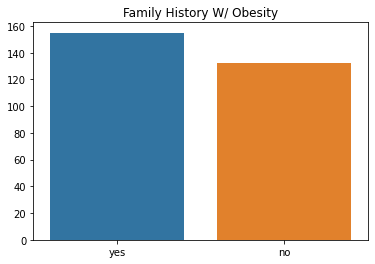

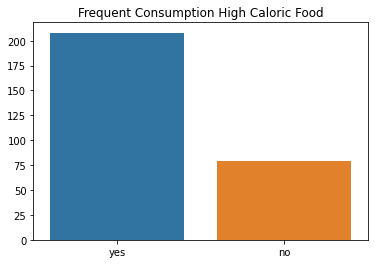

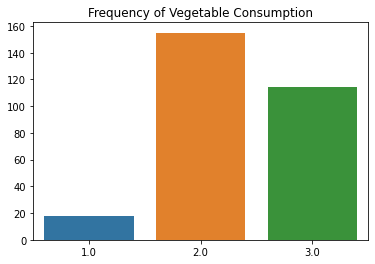

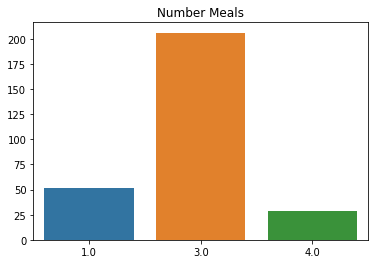

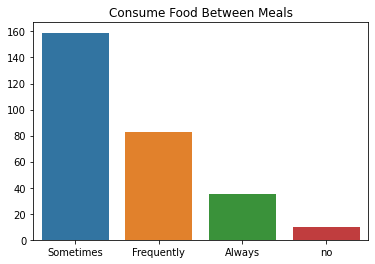

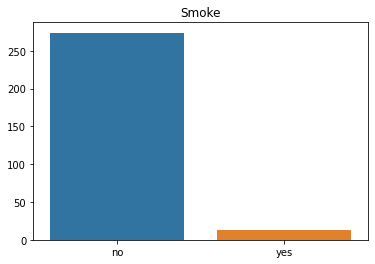

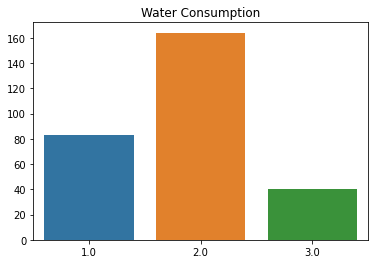

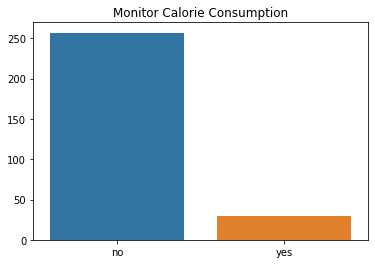

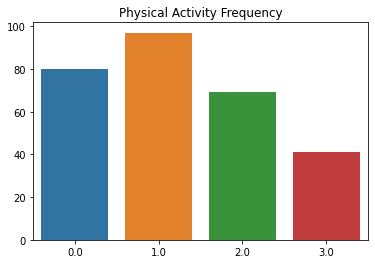

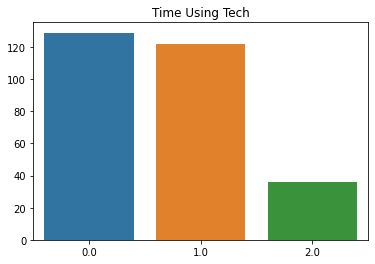

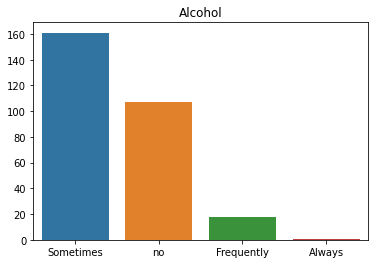

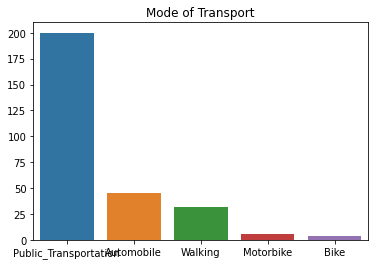

In [210]:
to_not_graph = ["Gender", "Age", "Weight", "Height", "Obesity"]
obesity = ds["Obesity"].unique()
sub_df = ds.loc[ds["Obesity"] == obesity[0]]
print(obesity[0])
for col in sub_df.columns:
    if col in to_not_graph:
        continue
    else:
        plt.figure()
        ax = sb.barplot(x=sub_df[col].value_counts().index.to_list(), y = sub_df[col].value_counts().to_list())
        plt.title(col)

Overweight_Level_I


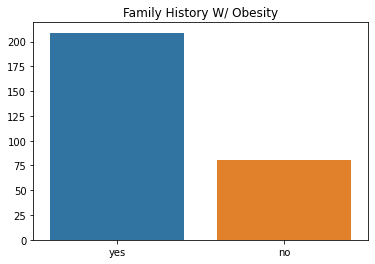

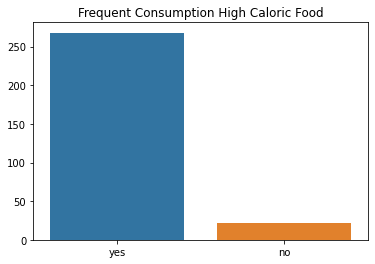

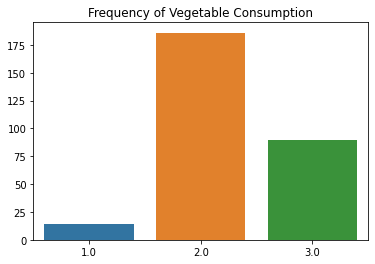

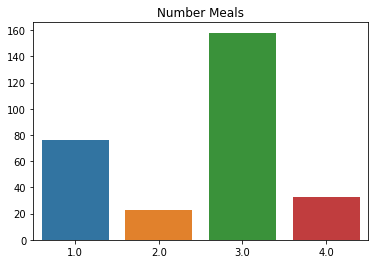

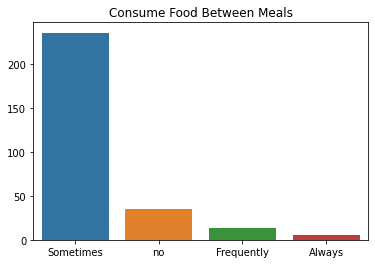

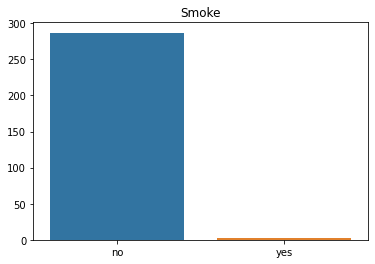

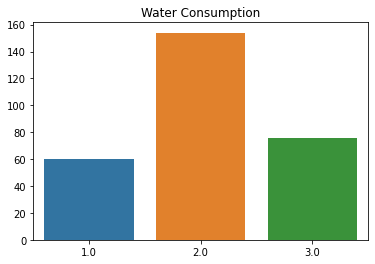

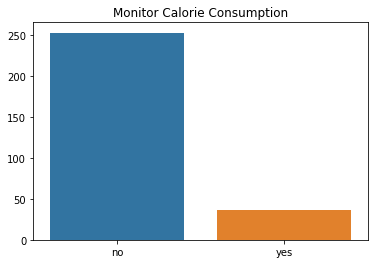

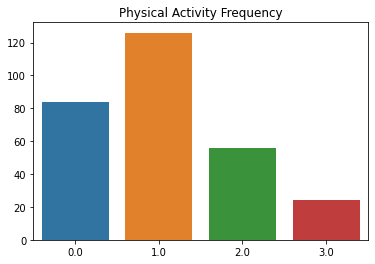

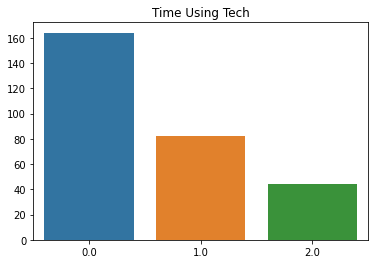

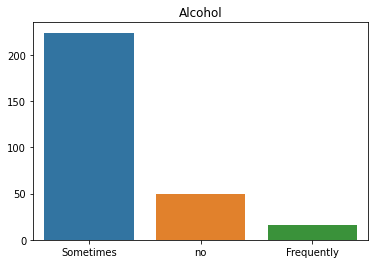

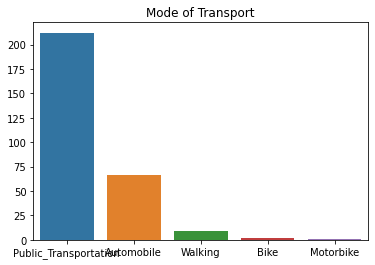

In [211]:
sub_df = ds.loc[ds["Obesity"] == obesity[1]]
print(obesity[1])
for col in sub_df.columns:
    if col in to_not_graph:
        continue
    else:
        plt.figure()
        ax = sb.barplot(x=sub_df[col].value_counts().index.to_list(), y = sub_df[col].value_counts().to_list())
        plt.title(col)

Overweight_Level_II


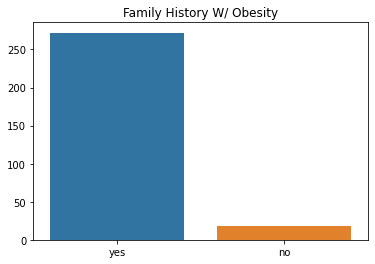

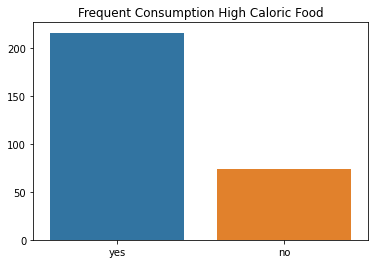

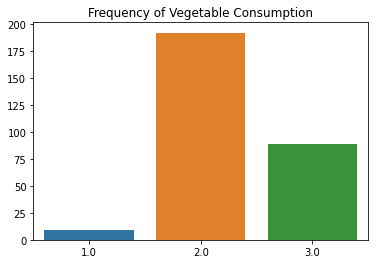

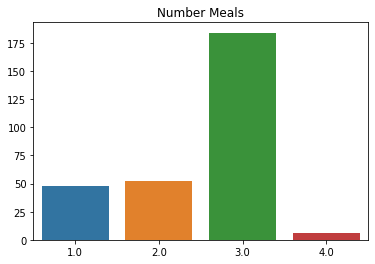

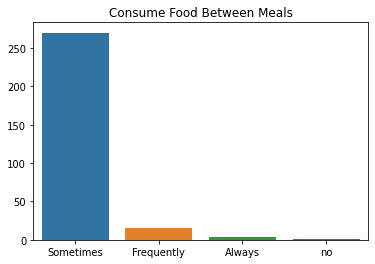

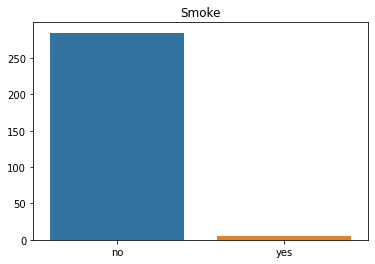

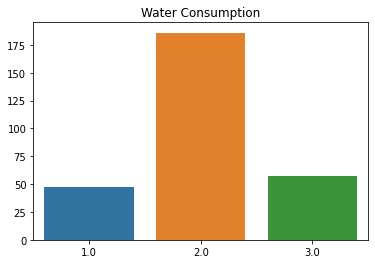

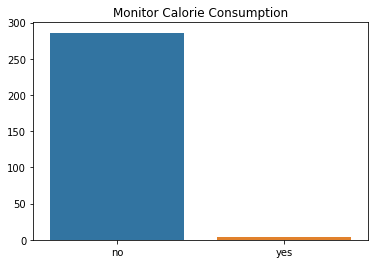

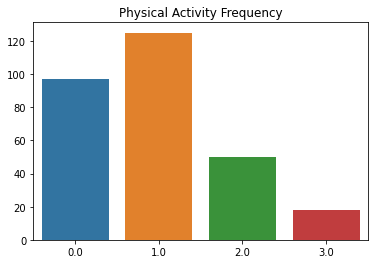

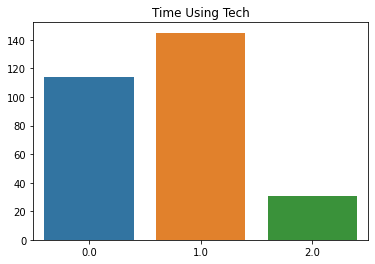

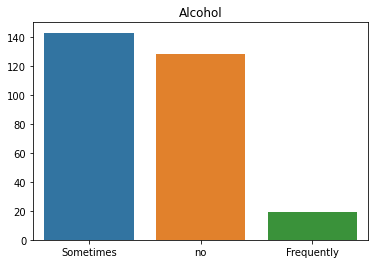

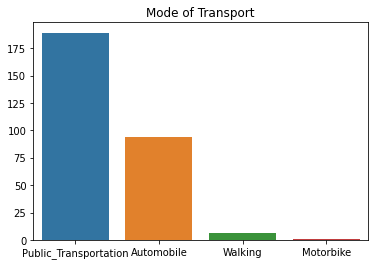

In [212]:
sub_df = ds.loc[ds["Obesity"] == obesity[2]]
print(obesity[2])
for col in sub_df.columns:
    if col in to_not_graph:
        continue
    else:
        plt.figure()
        ax = sb.barplot(x=sub_df[col].value_counts().index.to_list(), y = sub_df[col].value_counts().to_list())
        plt.title(col)

Obesity_Type_I


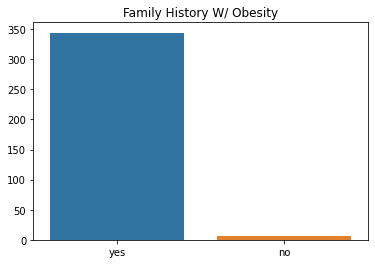

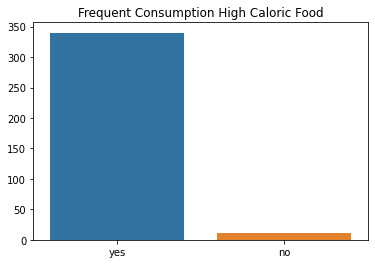

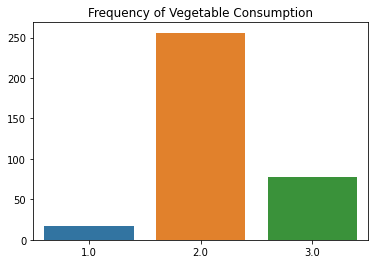

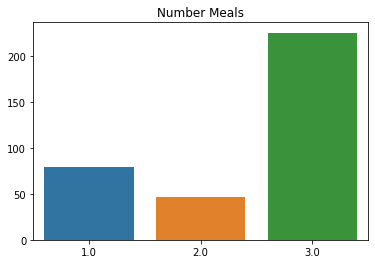

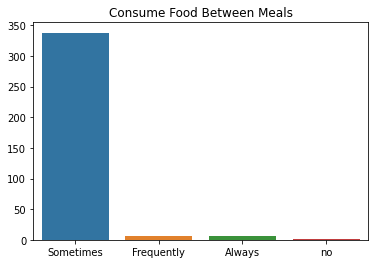

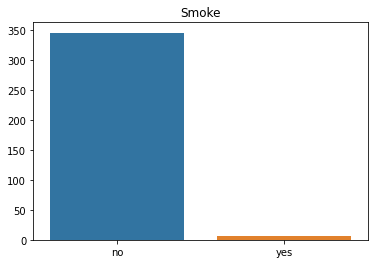

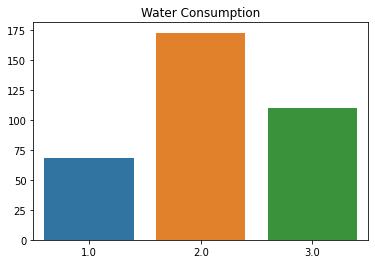

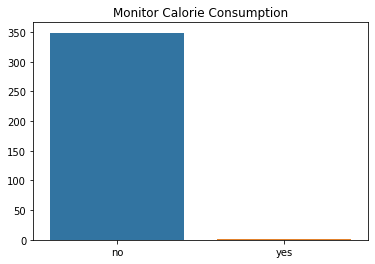

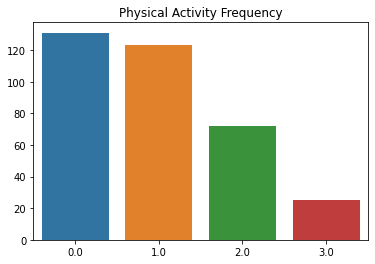

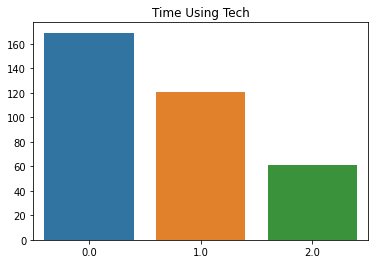

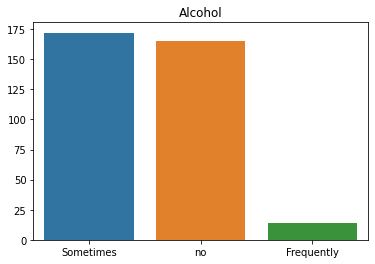

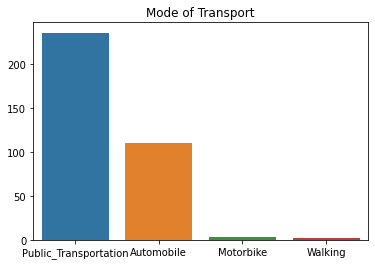

In [213]:
sub_df = ds.loc[ds["Obesity"] == obesity[3]]
print(obesity[3])
for col in sub_df.columns:
    if col in to_not_graph:
        continue
    else:
        plt.figure()
        ax = sb.barplot(x=sub_df[col].value_counts().index.to_list(), y = sub_df[col].value_counts().to_list())
        plt.title(col)

Insufficient_Weight


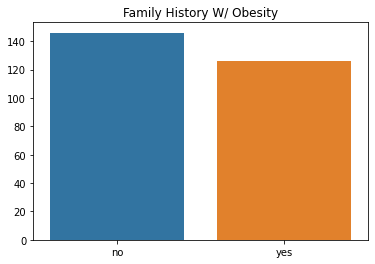

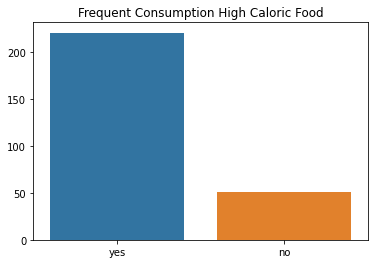

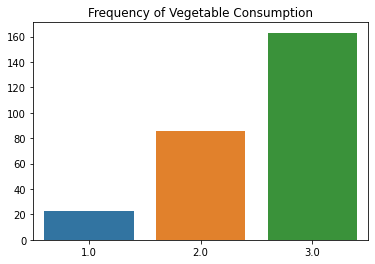

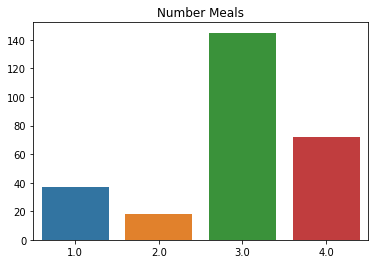

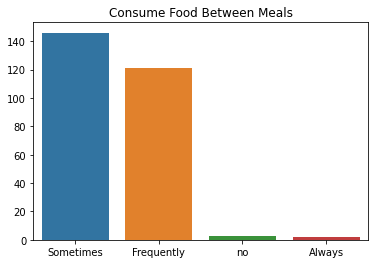

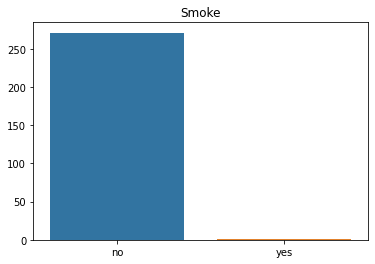

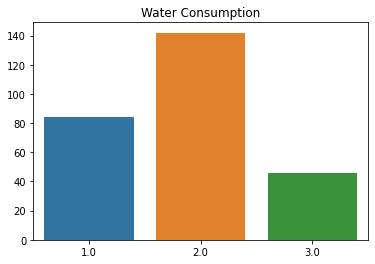

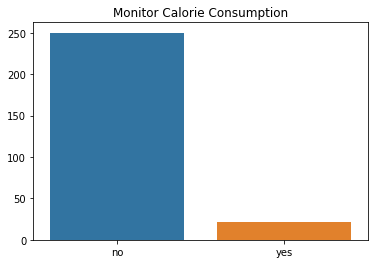

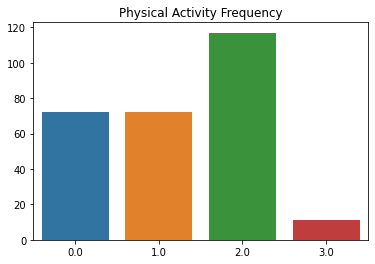

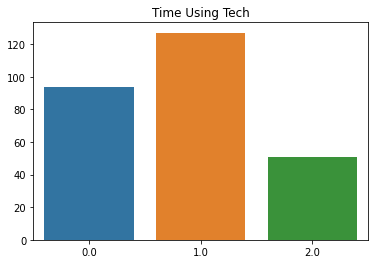

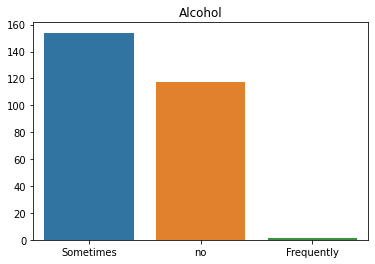

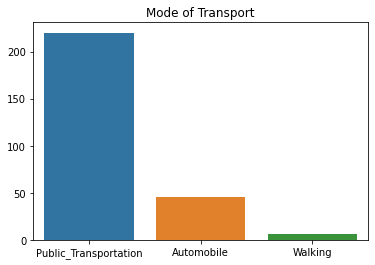

In [214]:
sub_df = ds.loc[ds["Obesity"] == obesity[4]]
print(obesity[4])
for col in sub_df.columns:
    if col in to_not_graph:
        continue
    else:
        plt.figure()
        ax = sb.barplot(x=sub_df[col].value_counts().index.to_list(), y = sub_df[col].value_counts().to_list())
        plt.title(col)

Obesity_Type_II


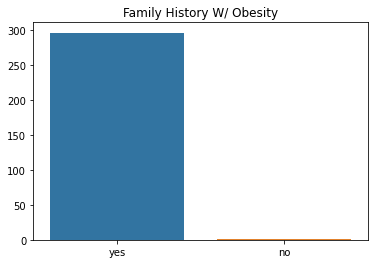

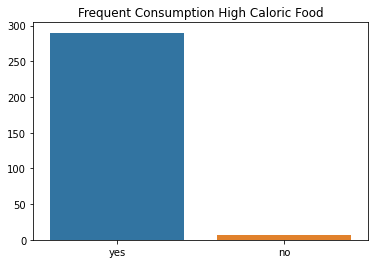

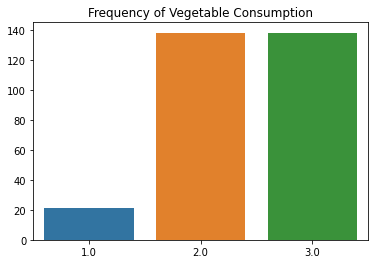

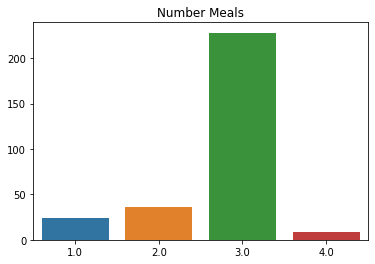

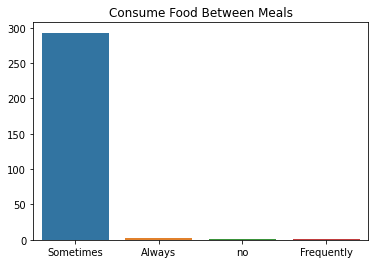

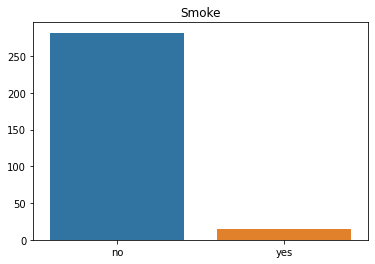

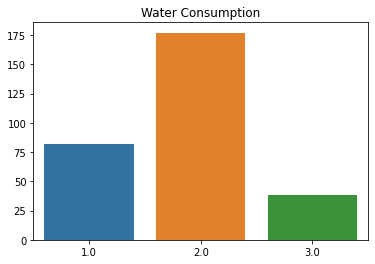

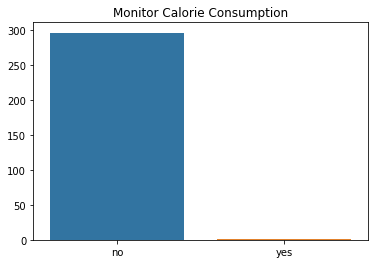

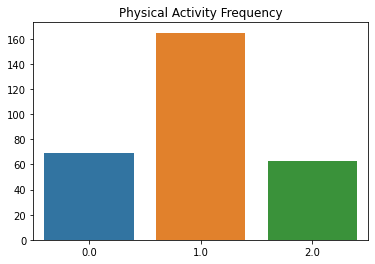

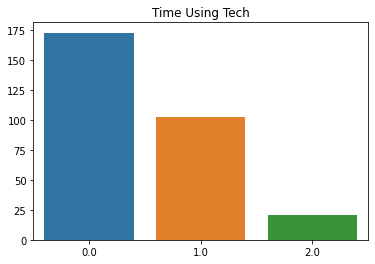

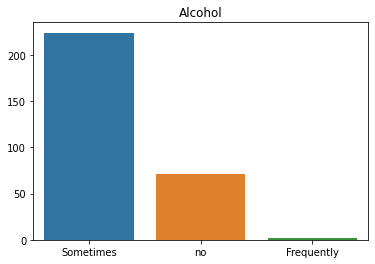

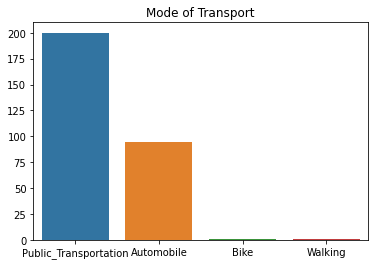

In [215]:
sub_df = ds.loc[ds["Obesity"] == obesity[5]]
print(obesity[5])
for col in sub_df.columns:
    if col in to_not_graph:
        continue
    else:
        plt.figure()
        ax = sb.barplot(x=sub_df[col].value_counts().index.to_list(), y = sub_df[col].value_counts().to_list())
        plt.title(col)

Obesity_Type_III


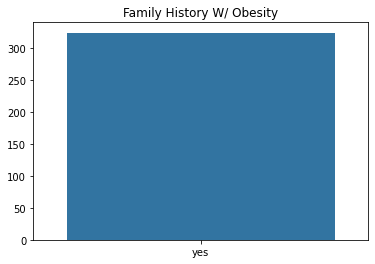

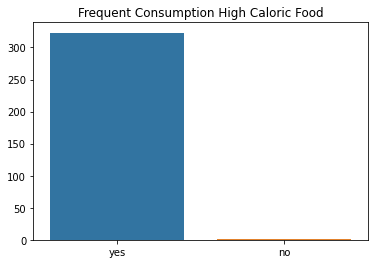

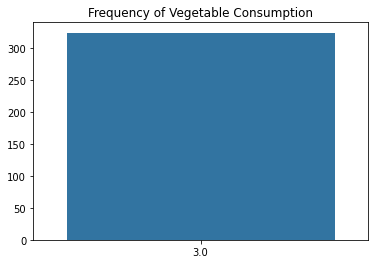

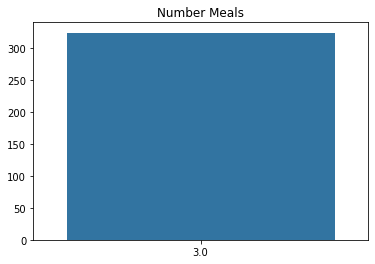

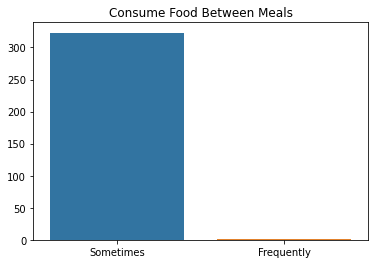

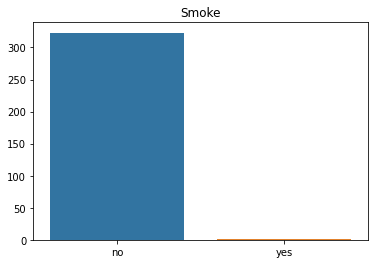

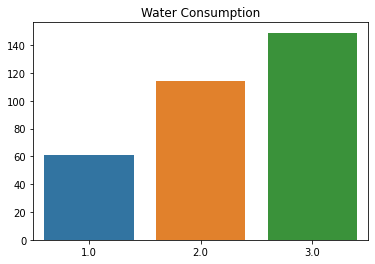

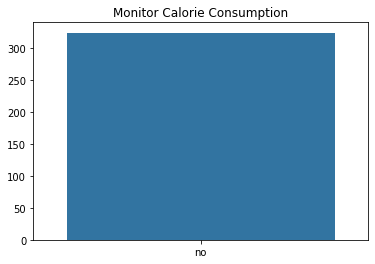

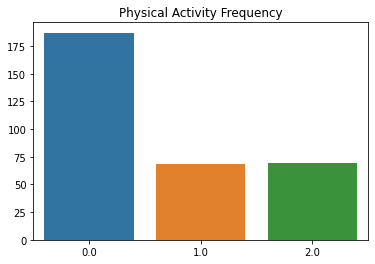

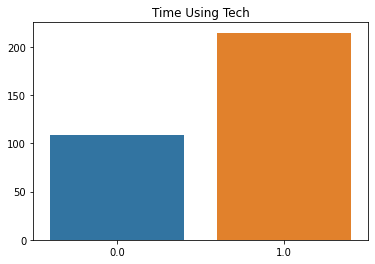

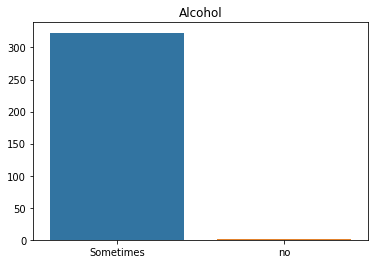

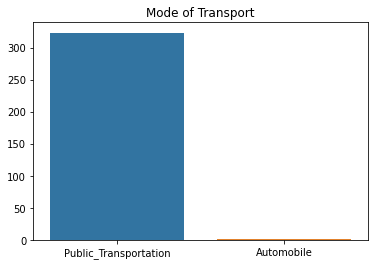

In [216]:
sub_df = ds.loc[ds["Obesity"] == obesity[6]]
print(obesity[6])
for col in sub_df.columns:
    if col in to_not_graph:
        continue
    else:
        plt.figure()
        ax = sb.barplot(x=sub_df[col].value_counts().index.to_list(), y = sub_df[col].value_counts().to_list())
        plt.title(col)

Intuitively weight and obesity should be highly correlated.  Let's 
visualize it.

We need to preprocess our data.  Since we are working with categorical data, let's transform our numerical into categorical.

In [217]:
cols_to_norm = ["Age", "Height", "Weight"]
ds[cols_to_norm] = preprocessing.minmax_scale(ds[cols_to_norm])

In [218]:
ds

,Gender,Age,Height,Weight,Family History W/ Obesity,Frequent Consumption High Caloric Food,Frequency of Vegetable Consumption,Number Meals,Consume Food Between Meals,Smoke,Water Consumption,Monitor Calorie Consumption,Physical Activity Frequency,Time Using Tech,Alcohol,Mode of Transport,Obesity
0,Female,0.148936,0.320755,0.186567,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,0.148936,0.132075,0.126866,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,0.191489,0.660377,0.283582,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,0.276596,0.660377,0.358209,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,0.170213,0.622642,0.380597,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,0.148936,0.490566,0.686567,yes,yes,3.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,0.170213,0.566038,0.708955,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,0.191489,0.566038,0.708955,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,0.212766,0.547170,0.701493,yes,yes,3.0,3.0,Sometimes,no,3.0,no,1.0,1.0,Sometimes,Public_Transportation,Obesity_Type_III


In [231]:
# Factorize our non numerical.
cols_to_disc = list()
for column in ds.columns:
    if isinstance(ds[column][0], (int, float)):
        continue
    else:
        cols_to_disc.append(column)
for col in cols_to_disc:
    if col == "Obesity":
        continue
    ds[col], uniques = pd.factorize(ds[col], sort=True)
ds

,Gender,Age,Height,Weight,Family History W/ Obesity,Frequent Consumption High Caloric Food,Frequency of Vegetable Consumption,Number Meals,Consume Food Between Meals,Smoke,Water Consumption,Monitor Calorie Consumption,Physical Activity Frequency,Time Using Tech,Alcohol,Mode of Transport,Obesity
0,0,0.148936,0.320755,0.186567,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,Normal_Weight
1,0,0.148936,0.132075,0.126866,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,Normal_Weight
2,1,0.191489,0.660377,0.283582,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,Normal_Weight
3,1,0.276596,0.660377,0.358209,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,Overweight_Level_I
4,1,0.170213,0.622642,0.380597,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,0.148936,0.490566,0.686567,1,1,3.0,3.0,2,0,2.0,0,2.0,1.0,2,3,Obesity_Type_III
2107,0,0.170213,0.566038,0.708955,1,1,3.0,3.0,2,0,2.0,0,1.0,1.0,2,3,Obesity_Type_III
2108,0,0.191489,0.566038,0.708955,1,1,3.0,3.0,2,0,2.0,0,1.0,1.0,2,3,Obesity_Type_III
2109,0,0.212766,0.547170,0.701493,1,1,3.0,3.0,2,0,3.0,0,1.0,1.0,2,3,Obesity_Type_III


In [301]:
X = ds.drop(["Obesity"], axis=1)
X

,Gender,Age,Height,Weight,Family History W/ Obesity,Frequent Consumption High Caloric Food,Frequency of Vegetable Consumption,Number Meals,Consume Food Between Meals,Smoke,Water Consumption,Monitor Calorie Consumption,Physical Activity Frequency,Time Using Tech,Alcohol,Mode of Transport
0,0,0.148936,0.320755,0.186567,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3
1,0,0.148936,0.132075,0.126866,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3
2,1,0.191489,0.660377,0.283582,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3
3,1,0.276596,0.660377,0.358209,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4
4,1,0.170213,0.622642,0.380597,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,0.148936,0.490566,0.686567,1,1,3.0,3.0,2,0,2.0,0,2.0,1.0,2,3
2107,0,0.170213,0.566038,0.708955,1,1,3.0,3.0,2,0,2.0,0,1.0,1.0,2,3
2108,0,0.191489,0.566038,0.708955,1,1,3.0,3.0,2,0,2.0,0,1.0,1.0,2,3
2109,0,0.212766,0.547170,0.701493,1,1,3.0,3.0,2,0,3.0,0,1.0,1.0,2,3


In [302]:
y = ds['Obesity']
y

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: Obesity, Length: 2111, dtype: object

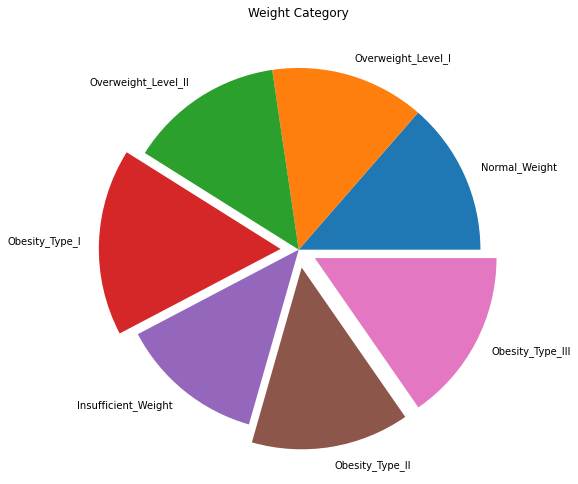

In [303]:
c = Counter(y)
fig = plt.figure(figsize=(8,8))
plt.pie([float(c[v]) for v in c], labels=[str(k) for k in c], autopct=None, explode = [0, 0, 0, 0.1, 0, 0.1, 0.1])
plt.title('Weight Category')
string = "pie.png"
plt.tight_layout()

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.20)

In [305]:
#Check for even split.
ctrain = Counter(y_train)
ctest  = Counter(y_test)
print("Train Ratio: {0}  Test Ratio: {1}".format(ctrain, ctest))

Train Ratio: Counter({'Obesity_Type_I': 293, 'Obesity_Type_III': 258, 'Overweight_Level_II': 236, 'Obesity_Type_II': 233, 'Normal_Weight': 230, 'Overweight_Level_I': 220, 'Insufficient_Weight': 218})  Test Ratio: Counter({'Overweight_Level_I': 70, 'Obesity_Type_III': 66, 'Obesity_Type_II': 64, 'Obesity_Type_I': 58, 'Normal_Weight': 57, 'Overweight_Level_II': 54, 'Insufficient_Weight': 54})


In [306]:
knn_models = dict()
for i in range(1, 31):
    knn_models["knn_" + str(i)] = [knn(n_neighbors = i)]

In [307]:
for key, value in knn_models.items():
    value[0].fit(X_train, y_train)
    value.append(value[0].predict(X_test))
    value.append(value[0].score(X_test, y_test))
    value.append(metrics.classification_report(y_test, value[1], digits=3))


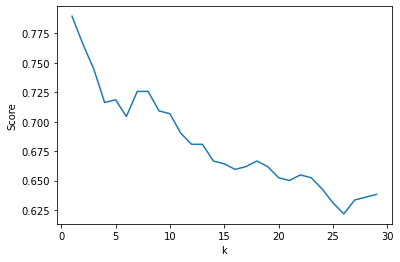

In [308]:
k = np.arange(1,30)
scores = list()
for i in range(1,30):
    scores.append(knn_models["knn_"+ str(i)][2])

plt.plot(k, scores)
plt.xlabel("k")
plt.ylabel("Score")
plt.show()

In [309]:
am  = max(scores)
i1  = scores.index(am)
knnbest = scores[i1]

print("Scores best k: {0} with a score of {1}".format(k[i1], 
                                                      scores[i1]))

Scores best k: 1 with a score of 0.789598108747045


In [310]:
knn_models["knn_1"][3]

'                     precision    recall  f1-score   support\n\nInsufficient_Weight      0.847     0.926     0.885        54\n      Normal_Weight      0.595     0.386     0.468        57\n     Obesity_Type_I      0.677     0.759     0.715        58\n    Obesity_Type_II      0.896     0.938     0.916        64\n   Obesity_Type_III      1.000     1.000     1.000        66\n Overweight_Level_I      0.839     0.671     0.746        70\nOverweight_Level_II      0.616     0.833     0.709        54\n\n           accuracy                          0.790       423\n          macro avg      0.781     0.788     0.777       423\n       weighted avg      0.790     0.790     0.783       423\n'

In [311]:
nb_model = nb()
y_pred_nb = nb_model.fit(X_train, y_train).predict(X_test)
nb_model.score(X_test, y_test)
nbbest = nb_model.score(X_test, y_test)

In [312]:
metrics.classification_report(y_test, y_pred_nb)

'                     precision    recall  f1-score   support\n\nInsufficient_Weight       0.58      0.80      0.67        54\n      Normal_Weight       0.64      0.28      0.39        57\n     Obesity_Type_I       0.32      0.72      0.44        58\n    Obesity_Type_II       0.79      0.94      0.86        64\n   Obesity_Type_III       1.00      1.00      1.00        66\n Overweight_Level_I       0.73      0.31      0.44        70\nOverweight_Level_II       0.52      0.20      0.29        54\n\n           accuracy                           0.61       423\n          macro avg       0.66      0.61      0.59       423\n       weighted avg       0.67      0.61      0.60       423\n'

In [313]:
dt_models = dict()
for i in range(1, 17):
    dt_models["dt_" + str(i)] = [DT(random_state=0, max_depth=i)]

In [314]:
for key, value in dt_models.items():
    value[0].fit(X_train, y_train)
    value.append(value[0].predict(X_test))
    value.append(value[0].score(X_test, y_test))
    value.append(metrics.classification_report(y_test, value[1], digits=3))

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classificat

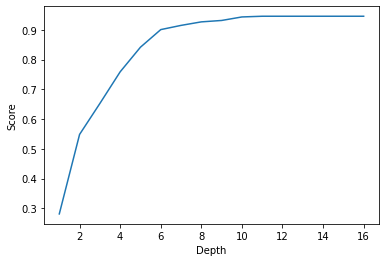

In [315]:
d = np.arange(1,17)
scoresdt = list()
for i in range(1,17):
    scoresdt.append(dt_models["dt_"+ str(i)][2])

plt.plot(d, scoresdt)
plt.xlabel("Depth")
plt.ylabel("Score")
plt.show()

In [316]:
am  = max(scoresdt)
i1  = scoresdt.index(am)
dtbest = scoresdt[i1]

print("Scores best depth: {0} with a score of {1}".format(d[i1], 
                                                          scoresdt[i1]))

Scores best depth: 11 with a score of 0.9456264775413712


[Text(208.22571716308593, 209.07692307692307, 'X[3] <= 0.451\ngini = 0.856\nsamples = 1688\nvalue = [218, 230, 293, 233, 258, 220, 236]'),
 Text(116.30846557617188, 192.35076923076923, 'X[3] <= 0.16\ngini = 0.801\nsamples = 1104\nvalue = [218, 230, 199, 5, 0, 220, 232]'),
 Text(46.100390625, 175.62461538461537, 'X[2] <= 0.406\ngini = 0.474\nsamples = 335\nvalue = [216, 111, 0, 0, 0, 7, 1]'),
 Text(20.271093750000002, 158.89846153846153, 'X[3] <= 0.056\ngini = 0.539\nsamples = 182\nvalue = [80, 94, 0, 0, 0, 7, 1]'),
 Text(7.846875000000001, 142.1723076923077, 'X[2] <= 0.123\ngini = 0.149\nsamples = 74\nvalue = [68, 6, 0, 0, 0, 0, 0]'),
 Text(5.23125, 125.44615384615385, 'gini = 0.0\nsamples = 3\nvalue = [0, 3, 0, 0, 0, 0, 0]'),
 Text(10.4625, 125.44615384615385, 'X[1] <= 0.223\ngini = 0.081\nsamples = 71\nvalue = [68, 3, 0, 0, 0, 0, 0]'),
 Text(5.23125, 108.72, 'X[1] <= 0.053\ngini = 0.029\nsamples = 68\nvalue = [67, 1, 0, 0, 0, 0, 0]'),
 Text(2.615625, 91.99384615384615, 'gini = 0.0\ns

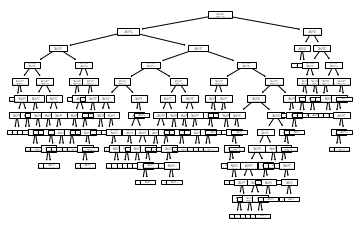

In [317]:
pt(dt_models["dt_12"][0])

In [339]:
ann = MLPClassifier(solver='lbfgs', alpha=1e-3, 
                    activation="relu", hidden_layer_sizes=(16, 11, 6), random_state=1, max_iter = 10000)

In [340]:
y_pred_ann = ann.fit(X_train, y_train).predict(X_test)

In [341]:
ann.score(X_test, y_test)
annbest = ann.score(X_test, y_test)

In [342]:
metrics.classification_report(y_test, y_pred_ann)

'                     precision    recall  f1-score   support\n\nInsufficient_Weight       0.83      1.00      0.91        54\n      Normal_Weight       0.88      0.88      0.88        57\n     Obesity_Type_I       0.93      0.93      0.93        58\n    Obesity_Type_II       1.00      0.97      0.98        64\n   Obesity_Type_III       1.00      1.00      1.00        66\n Overweight_Level_I       0.97      0.80      0.88        70\nOverweight_Level_II       0.88      0.93      0.90        54\n\n           accuracy                           0.93       423\n          macro avg       0.93      0.93      0.93       423\n       weighted avg       0.93      0.93      0.93       423\n'

In [343]:
svm_models = dict()
kernels = ["linear", "poly", "rbf", "sigmoid"]
for i in range(len(kernels)):
    svm_models["svm_" + str(i)] = [SVC(kernel=kernels[i], C=1, probability=True)]

In [323]:
for key, value in svm_models.items():
    value[0].fit(X_train, y_train)
    value.append(value[0].predict(X_test))
    value.append(value[0].score(X_test, y_test))
    value.append(metrics.classification_report(y_test, value[1], digits=3))

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


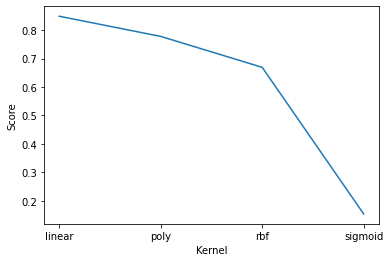

In [324]:
scoressvm = list()
for i in range(len(kernels)):
    scoressvm.append(svm_models["svm_"+ str(i)][2])

plt.plot(kernels, scoressvm)
plt.xlabel("Kernel")
plt.ylabel("Score")
plt.show()

In [325]:
am  = max(scoressvm)
i1  = scoressvm.index(am)


print("Best kernel: {0} with a score of {1}".format(kernels[i1], scoressvm[i1]))

Best kernel: linear with a score of 0.8486997635933806


In [326]:
# Now test linear with various C's
Cs = [0.25, 0.5, 1.0, 1.5, 2.0]
svmc_models = dict()
for i in range(len(Cs)):
    svmc_models["svmc_" + str(i)] = [SVC(kernel='linear', C=Cs[i], probability=True)]

In [327]:
for key, value in svmc_models.items():
    value[0].fit(X_train, y_train)
    value.append(value[0].predict(X_test))
    value.append(value[0].score(X_test, y_test))
    value.append(metrics.classification_report(y_test, value[1], digits=3))

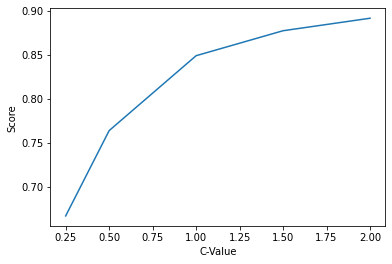

In [328]:
scoressvmc = list()
for i in range(len(Cs)):
    scoressvmc.append(svmc_models["svmc_"+ str(i)][2])

plt.plot(Cs, scoressvmc)
plt.xlabel("C-Value")
plt.ylabel("Score")
plt.show()

In [329]:
am  = max(scoressvmc)
i1  = scoressvmc.index(am)
svmbest = scoressvmc[i1]

print("Best kernel: {0} with a score of {1}".format(Cs[i1],
                                                    scoressvmc[i1]))

Best kernel: 2.0 with a score of 0.8912529550827423


In [330]:
model_rf = RF()
y_pred_rf = model_rf.fit(X_train, y_train).predict(X_test)

In [331]:
model_rf.score(X_test, y_test)
rfbest = model_rf.score(X_test, y_test)

In [332]:
metrics.classification_report(y_test, y_pred_rf)

'                     precision    recall  f1-score   support\n\nInsufficient_Weight       0.96      0.93      0.94        54\n      Normal_Weight       0.84      0.86      0.85        57\n     Obesity_Type_I       0.98      0.98      0.98        58\n    Obesity_Type_II       1.00      1.00      1.00        64\n   Obesity_Type_III       1.00      1.00      1.00        66\n Overweight_Level_I       0.94      0.96      0.95        70\nOverweight_Level_II       0.94      0.94      0.94        54\n\n           accuracy                           0.96       423\n          macro avg       0.95      0.95      0.95       423\n       weighted avg       0.96      0.96      0.96       423\n'

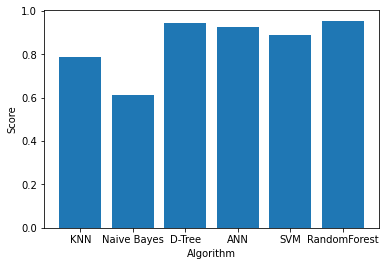

In [344]:
# Comparison of best algs
algs = ["KNN", "Naive Bayes", "D-Tree", "ANN", "SVM", "RandomForest"]
best_scores = [knnbest, nbbest, dtbest, annbest, svmbest, rfbest]
plt.bar(algs, best_scores)
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.show()

In [345]:
for i in range(len(algs)):
    print("{0} score: {1}".format(algs[i], best_scores[i]))

KNN score: 0.789598108747045
Naive Bayes score: 0.6146572104018913
D-Tree score: 0.9456264775413712
ANN score: 0.9267139479905437
SVM score: 0.8912529550827423
RandomForest score: 0.9550827423167849


In [346]:
# Now with 13 features.

X = ds.drop(["Age", "Height", "Weight", "Obesity"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.20)

In [347]:
knn_models = dict()
for i in range(1, 31):
    knn_models["knn_" + str(i)] = [knn(n_neighbors = i)]

In [348]:
for key, value in knn_models.items():
    value[0].fit(X_train, y_train)
    value.append(value[0].predict(X_test))
    value.append(value[0].score(X_test, y_test))
    value.append(metrics.classification_report(y_test, value[1], digits=3))


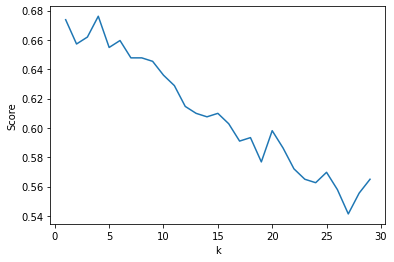

In [349]:
k = np.arange(1,30)
scores = list()
for i in range(1,30):
    scores.append(knn_models["knn_"+ str(i)][2])

plt.plot(k, scores)
plt.xlabel("k")
plt.ylabel("Score")
plt.show()

In [350]:
am  = max(scores)
i1  = scores.index(am)
knnbest = scores[i1]

print("Scores best k: {0} with a score of {1}".format(k[i1], 
                                                      scores[i1]))

Scores best k: 4 with a score of 0.6761229314420804


In [351]:
nb_model = nb()
y_pred_nb = nb_model.fit(X_train, y_train).predict(X_test)
nb_model.score(X_test, y_test)
nbbest = nb_model.score(X_test, y_test)

In [352]:
metrics.classification_report(y_test, y_pred_nb)

'                     precision    recall  f1-score   support\n\nInsufficient_Weight       0.50      0.54      0.52        54\n      Normal_Weight       0.41      0.21      0.28        58\n     Obesity_Type_I       0.43      0.42      0.42        62\n    Obesity_Type_II       0.39      0.94      0.55        63\n   Obesity_Type_III       1.00      0.99      0.99        74\n Overweight_Level_I       0.35      0.17      0.23        54\nOverweight_Level_II       0.56      0.24      0.34        58\n\n           accuracy                           0.52       423\n          macro avg       0.52      0.50      0.47       423\n       weighted avg       0.54      0.52      0.50       423\n'

In [353]:
dt_models = dict()
for i in range(1, 17):
    dt_models["dt_" + str(i)] = [DT(random_state=0, max_depth=i)]

In [354]:
for key, value in dt_models.items():
    value[0].fit(X_train, y_train)
    value.append(value[0].predict(X_test))
    value.append(value[0].score(X_test, y_test))
    value.append(metrics.classification_report(y_test, value[1], digits=3))

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classificat

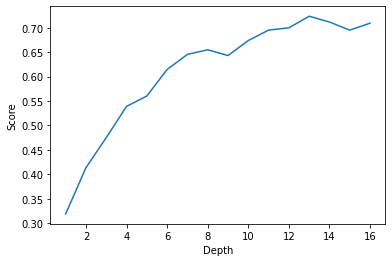

In [355]:
d = np.arange(1,17)
scoresdt = list()
for i in range(1,17):
    scoresdt.append(dt_models["dt_"+ str(i)][2])

plt.plot(d, scoresdt)
plt.xlabel("Depth")
plt.ylabel("Score")
plt.show()

In [356]:
am  = max(scoresdt)
i1  = scoresdt.index(am)
dtbest = scoresdt[i1]

print("Scores best depth: {0} with a score of {1}".format(d[i1], 
                                                          scoresdt[i1]))

Scores best depth: 13 with a score of 0.723404255319149


In [357]:
ann = MLPClassifier(solver='lbfgs', alpha=1e-3, 
                    activation="relu", hidden_layer_sizes=(16, 11, 6), random_state=1, max_iter = 10000)

In [358]:
y_pred_ann = ann.fit(X_train, y_train).predict(X_test)

In [359]:
ann.score(X_test, y_test)
annbest = ann.score(X_test, y_test)

In [360]:
metrics.classification_report(y_test, y_pred_ann)

'                     precision    recall  f1-score   support\n\nInsufficient_Weight       0.78      0.70      0.74        54\n      Normal_Weight       0.55      0.50      0.52        58\n     Obesity_Type_I       0.53      0.76      0.62        62\n    Obesity_Type_II       0.79      0.84      0.82        63\n   Obesity_Type_III       0.99      0.97      0.98        74\n Overweight_Level_I       0.37      0.30      0.33        54\nOverweight_Level_II       0.45      0.38      0.41        58\n\n           accuracy                           0.65       423\n          macro avg       0.64      0.64      0.63       423\n       weighted avg       0.65      0.65      0.65       423\n'

In [361]:
svm_models = dict()
kernels = ["linear", "poly", "rbf", "sigmoid"]
for i in range(len(kernels)):
    svm_models["svm_" + str(i)] = [SVC(kernel=kernels[i], C=1, probability=True)]

In [362]:
for key, value in svm_models.items():
    value[0].fit(X_train, y_train)
    value.append(value[0].predict(X_test))
    value.append(value[0].score(X_test, y_test))
    value.append(metrics.classification_report(y_test, value[1], digits=3))

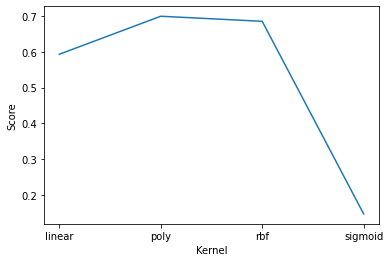

In [363]:
scoressvm = list()
for i in range(len(kernels)):
    scoressvm.append(svm_models["svm_"+ str(i)][2])

plt.plot(kernels, scoressvm)
plt.xlabel("Kernel")
plt.ylabel("Score")
plt.show()

In [364]:
am  = max(scoressvm)
i1  = scoressvm.index(am)


print("Best kernel: {0} with a score of {1}".format(kernels[i1], scoressvm[i1]))

Best kernel: poly with a score of 0.6997635933806147


In [365]:
# Now test linear with various C's
Cs = [0.25, 0.5, 1.0, 1.5, 2.0]
svmc_models = dict()
for i in range(len(Cs)):
    svmc_models["svmc_" + str(i)] = [SVC(kernel='linear', C=Cs[i], probability=True)]

In [366]:
for key, value in svmc_models.items():
    value[0].fit(X_train, y_train)
    value.append(value[0].predict(X_test))
    value.append(value[0].score(X_test, y_test))
    value.append(metrics.classification_report(y_test, value[1], digits=3))

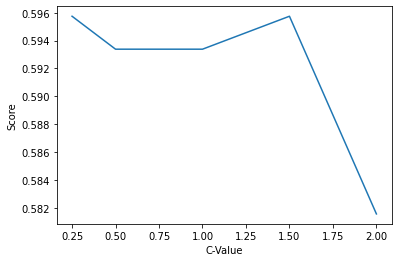

In [367]:
scoressvmc = list()
for i in range(len(Cs)):
    scoressvmc.append(svmc_models["svmc_"+ str(i)][2])

plt.plot(Cs, scoressvmc)
plt.xlabel("C-Value")
plt.ylabel("Score")
plt.show()

In [368]:
am  = max(scoressvmc)
i1  = scoressvmc.index(am)
svmbest = scoressvmc[i1]

print("Best kernel: {0} with a score of {1}".format(Cs[i1],
                                                    scoressvmc[i1]))

Best kernel: 0.25 with a score of 0.5957446808510638


In [369]:
model_rf = RF()
y_pred_rf = model_rf.fit(X_train, y_train).predict(X_test)

In [370]:
model_rf.score(X_test, y_test)
rfbest = model_rf.score(X_test, y_test)

In [371]:
metrics.classification_report(y_test, y_pred_rf)

'                     precision    recall  f1-score   support\n\nInsufficient_Weight       0.77      0.76      0.77        54\n      Normal_Weight       0.59      0.59      0.59        58\n     Obesity_Type_I       0.64      0.79      0.71        62\n    Obesity_Type_II       0.85      0.92      0.89        63\n   Obesity_Type_III       1.00      0.97      0.99        74\n Overweight_Level_I       0.70      0.48      0.57        54\nOverweight_Level_II       0.61      0.62      0.62        58\n\n           accuracy                           0.75       423\n          macro avg       0.74      0.73      0.73       423\n       weighted avg       0.75      0.75      0.74       423\n'

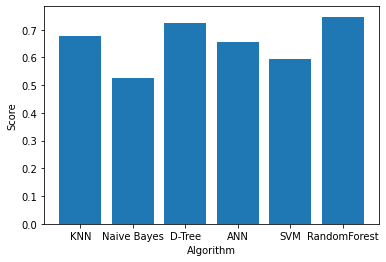

In [372]:
# Comparison of best algs
algs = ["KNN", "Naive Bayes", "D-Tree", "ANN", "SVM", "RandomForest"]
best_scores = [knnbest, nbbest, dtbest, annbest, svmbest, rfbest]
plt.bar(algs, best_scores)
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.show()

In [373]:
for i in range(len(algs)):
    print("{0} score: {1}".format(algs[i], best_scores[i]))

KNN score: 0.6761229314420804
Naive Bayes score: 0.524822695035461
D-Tree score: 0.723404255319149
ANN score: 0.6548463356973995
SVM score: 0.5957446808510638
RandomForest score: 0.7470449172576832
